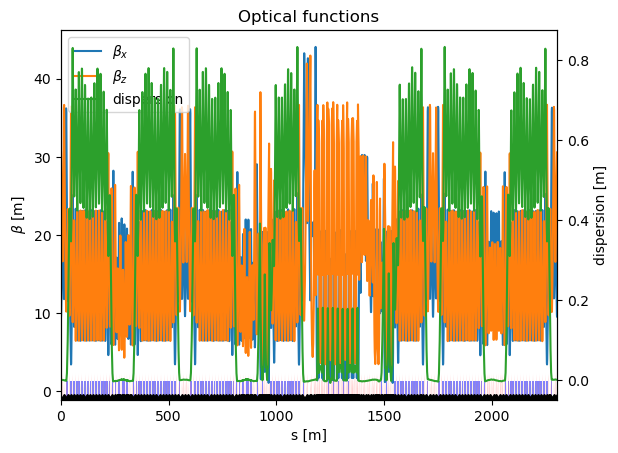

The lattice p3_v24 has 246 BPMs both planes Hor and Ver , 438 Correctors, 230 Sextupoles, and 417 quadrupoles with 193 quads families and 16 skew quads. Number of used correctors = 219 Hor and = 194 Ver
The ideal lattice tune values: [37.12799969 30.27187036], The chromaticity values: [-0.19327199 -0.1516299 ]. 


In [2]:
import numpy as np

from at_modules_loco import *
from data_loader import load_data,load_indices

# load lattice
lattice_name = 'p3_v24'
ring = at.load_mat(lattice_name)
ring.plot_beta()
ring.radiation_off()

#ring.radiation_on()
#ring.enable_6d()
#at.set_rf_frequency(ring)
#at.set_cavity_phase(ring)


#Loading data & parameters

C_measured, C_model, Noise_BPMx, Noise_BPMy, BPM_names, HCM_names, VCM_names, Jn= load_data(ring)
quads_indices, skew_indices,quad_fam_names, quads_fam_indices, bpm_indices, corrector_indices, dipole_indices,hcm_index,vcm_index,sext_indexes, bpm_x_ind, bpm_y_ind,nominal_crom, nominal_tune = load_indices(ring)
Jn = Full_Jacobian(Jn , C_model, hcm_index, vcm_index, bpm_x_ind, bpm_y_ind)

[elemdata0, beamdata, elemdata] = at.get_optics(ring, bpm_indices)
twiss = elemdata
print('The lattice {} has {} BPMs both planes Hor and Ver , {} Correctors, {} Sextupoles, and {} quadrupoles with {} quads families and {} skew quads. Number of used correctors = {} Hor and = {} Ver'.format(lattice_name, len(BPM_names), len(HCM_names)+len(HCM_names),  len(sext_indexes), len(quads_indices), len(quads_fam_indices),len(skew_indices),len(HCM_names), len(VCM_names)))
print(f"The ideal lattice tune values: {nominal_tune}, "
      f"The chromaticity values: {nominal_crom}. ")

ring0 = deepcopy(ring)
# quads and correctors kick
correctors_kick = 50.e-6
dk = 1.e-3

# Model ORM & Jacobian

#C_model = model_orm(correctors_kick, ring,  hcm_index, vcm_index, bpm_x_ind,bpm_y_ind, includeDispersion=False, include_coupling=True)
#Jn = calculate_jacobian(ring, quads_fam_indices, C_model, correctors_kick, hcm_index ,vcm_index, bpm_x_ind, bpm_y_ind, dk
#                      , includeDispersion=False,include_coupling = True,
#                       skew=False, family=True, full_jacobian=True)


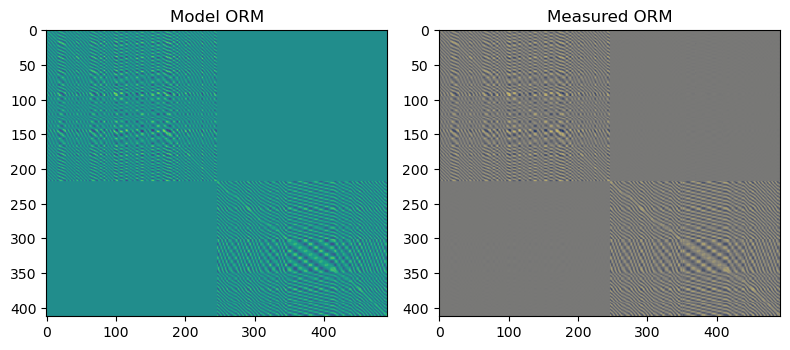

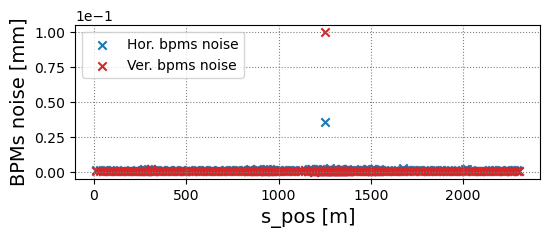

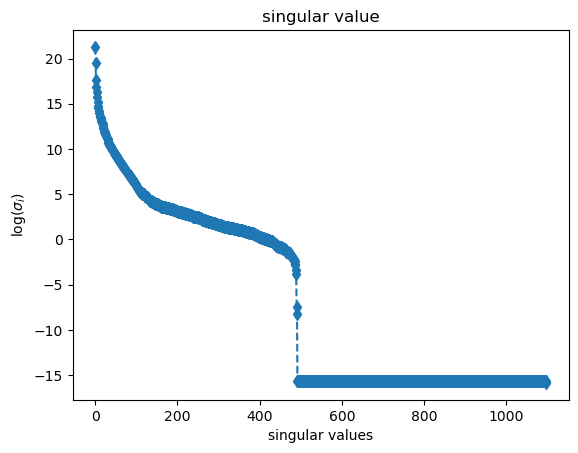

In [3]:
# In[34]:

C_measured =  C_measured *10
plot_orm(C_model, C_measured)
Weight= weight_matrix(ring, Noise_BPMx, Noise_BPMy, show_plot=True)


total_length = len(quads_fam_indices) + len(hcm_index) + len(vcm_index) + len(bpm_x_ind) + len(bpm_y_ind)
lengths = [len(quads_fam_indices) ,len(hcm_index) + len(vcm_index),  len(bpm_x_ind) + len(bpm_y_ind)]
including_fit_parameters = ['quads', 'cor', 'bpm']

# Initial guess of fit parameters

initial_guess = np.zeros(total_length)
initial_guess[:lengths[0]]= 1e-6 #quads
initial_guess[lengths[0]:lengths[0] + lengths[1] ]= 1e-6 # cor
initial_guess[lengths[0] + lengths[1] :] = 1e-6 # bpms

# Check SVD cut off
n_resp_mats = len(Jn)
sum_corr = np.sum(Jn, axis=1)
matrix = np.dot(np.dot(sum_corr, Weight), sum_corr.T)
u, s, v = np.linalg.svd(matrix, full_matrices=True)
plt.plot(np.log(s), 'd--')
plt.title('singular value')
plt.xlabel('singular values')
plt.ylabel('$\log(\sigma_i)$')
plt.show()

smat = 0.0 * matrix
si = s ** -1
sCut = 20 # Cut off
si[sCut:] *= 0.0
Nk = len(matrix)
smat[:Nk, :Nk] = np.diag(si)
Jt = np.dot(v.transpose(), np.dot(smat.transpose(), u.transpose()))

LOCO iteration 0
 BPM_to_corrector_response_matrices (Measured) ..


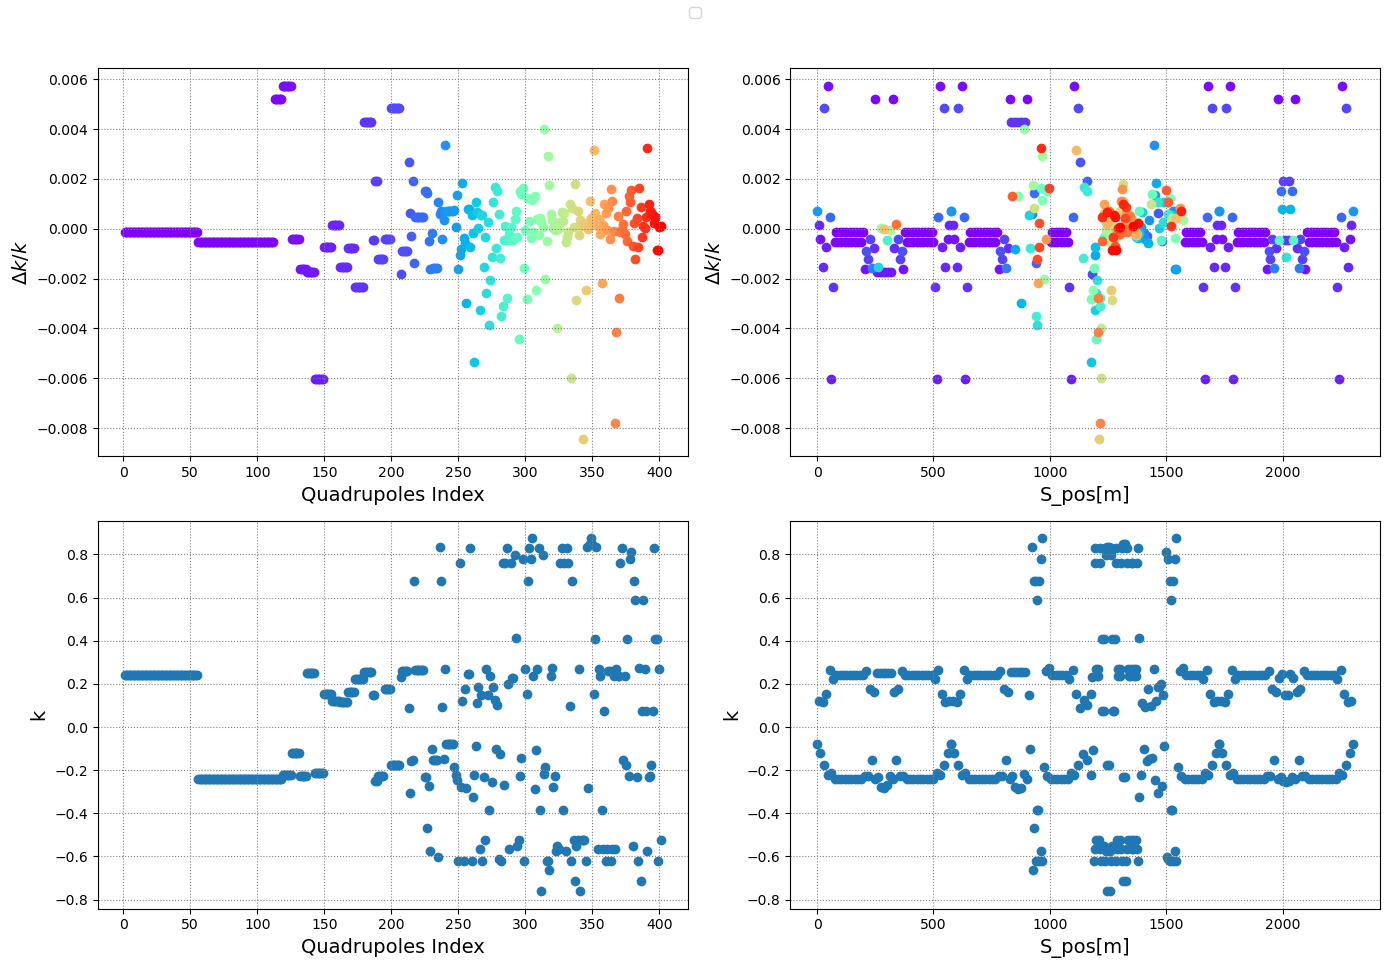

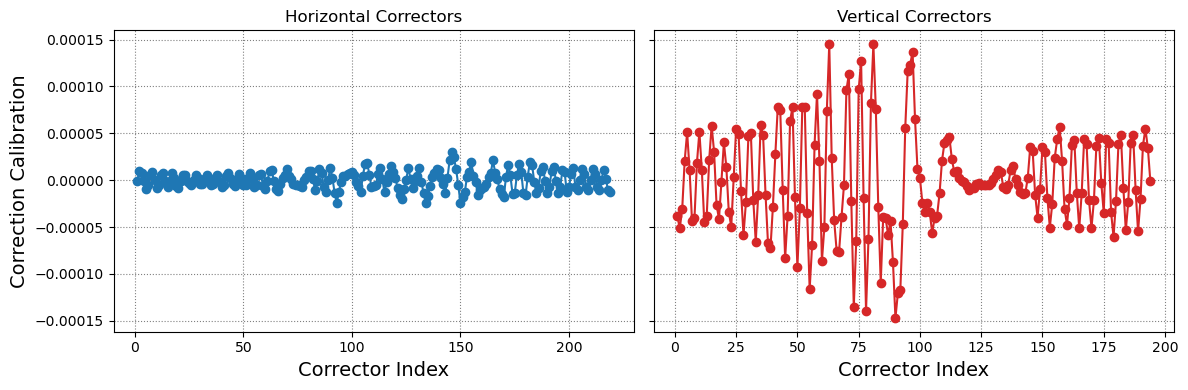

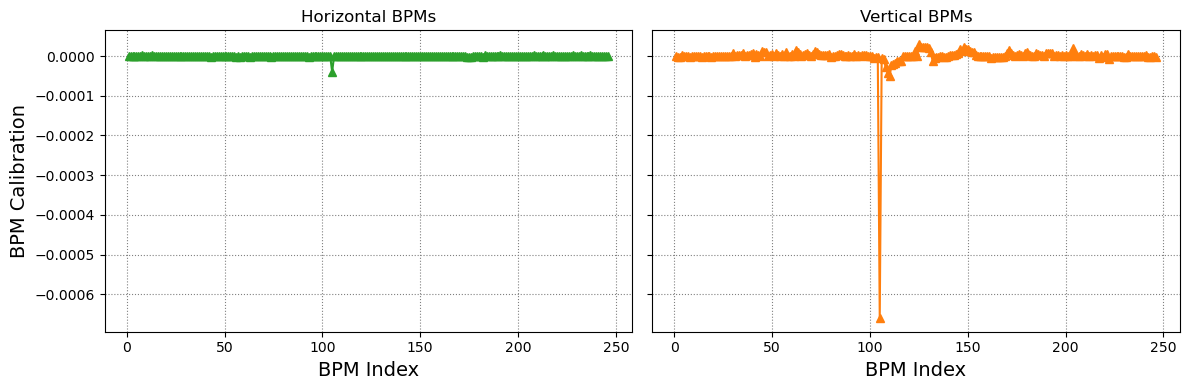

The maximum value in the list of quad_strength was 0.005744354603036739 for the quad family QK1, which has a nominal strength of -0.22245 and strength with error is -0.22245 and dk = 0.0.
The minimum value in the list of quad_strength was -0.008421437561013618 for the quad family QA3_NOR_59, which has a nominal strength of -0.5213124545 and strength with error is -0.5213124545 and dk = 0.0.
Beta beating after corrections


C:\Users\musa\Desktop\Optics-corrections-with-PyAT\Examples\PETRA III\at_modules_loco.py:976: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


RMS Beta-beating predicted by LOCO 'LM algorithm' using all normal quads families and cal:23.090042541546914 % horizontal 58.8771028976157 %


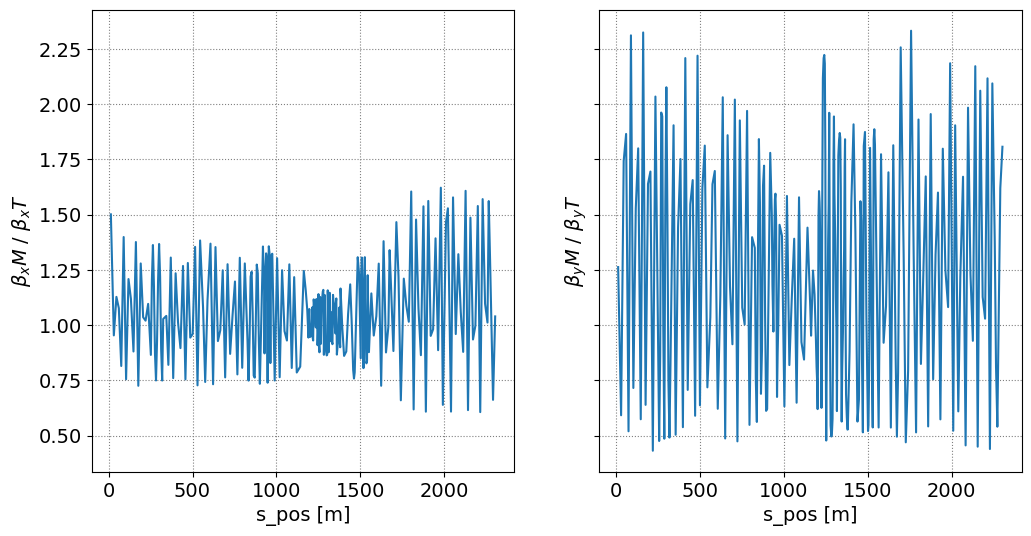

In [4]:
n_iter = 1
#sCut = 20

initial_guess0 =initial_guess
for x in range(n_iter):  # optics correction using QF and QD
    print(f'LOCO iteration {x}')


    print(" BPM_to_corrector_response_matrices (Measured) ..")   # Loaded before
    #C_measured = measured_orm(correctors_kick, ring, hcm_index,vcm_index, bpm_x_ind,bpm_y_ind, corx_calibration, cory_calibration, bpmx_calibration, bpmy_calibration, Hor_noise, Ver_noise, includeDispersion=False, include_coupling=True)


    fit_parameters  = loco_correction_ng(initial_guess0, C_model, C_measured, Jn, matrix, lengths, including_fit_parameters, sCut,  Weight)



    np.savetxt('fit_parameters_ng_cut20', fit_parameters)


    quad_strength = fit_parameters[:lengths[0]]
    cor_cal = fit_parameters[lengths[0]:lengths[0] + lengths[1] ]
    bpm_cal = fit_parameters[lengths[0] + lengths[1] :]

    plot_fit_parameters(ring,ring0,  quads_fam_indices, fit_parameters, lengths, including_fit_parameters, hcm_index, vcm_index,
                        bpm_x_ind, bpm_y_ind)

    index_of_max = np.argmax(quad_strength)
    max_value = np.max(quad_strength)
    max_quad_fam_name = quad_fam_names[index_of_max]
    ind = quads_fam_indices[index_of_max]
    k_of_max = ring0[ind[0]].K
    k_of_max_err = ring[ind[0]].K
    max_quad_fam_name = quad_fam_names[index_of_max]

    print(f"The maximum value in the list of quad_strength was {max_value} for the quad family {max_quad_fam_name}, which has a nominal strength of {k_of_max} and strength with error is {k_of_max_err} and dk = {k_of_max - k_of_max_err}.")

    index_of_min = np.argmin(quad_strength)
    min_value = np.min(quad_strength)
    min_quad_fam_name = quad_fam_names[index_of_min]
    ind = quads_fam_indices[index_of_min]


    k_of_min = ring0[ind[0]].K
    k_of_min_err = ring[ind[0]].K

    print(f"The minimum value in the list of quad_strength was {min_value} for the quad family {min_quad_fam_name}, which has a nominal strength of {k_of_min} and strength with error is {k_of_min_err} and dk = {k_of_min - k_of_min_err}.")

    #np.savetxt('fit_parameters_lm', fit_parameters)
    setCorrection(ring, quad_strength, quads_fam_indices,
                  add=False, skew=False, family=True)  # Note: For PETRA III examples the fit parameters were aded to the model lattice (option add = False)

    print('Beta beating after corrections')
    bx_rms_cor, by_rms_cor = model_beta_beat(ring, twiss, bpm_indices, plot = True)

    print(f"RMS Beta-beating predicted by LOCO 'LM algorithm' using all normal quads families and cal:{bx_rms_cor*100} % horizontal {by_rms_cor*100} %")
